In [1]:
from ple.games.flappybird import FlappyBird
from ple import PLE
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line disable pop-out window
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 2.5.2 (SDL 2.28.2, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_sn

In [2]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [3]:
# a dictionary describe state
'''
    player y position.
    players velocity.
    next pipe distance to player
    next pipe top y position
    next pipe bottom y position
    next next pipe distance to player
    next next pipe top y position
    next next pipe bottom y position
'''
game.getGameState()  

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': 144,
 'next_pipe_bottom_y': 244,
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': 160,
 'next_next_pipe_bottom_y': 260}

In [4]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx])  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * best_q - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE,
                                  min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                        ** ((episode) / 30)))

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [5]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [6]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2675:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No su

# Q-Learning

In [7]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0  
    t = 0

    while not env.game_over():

        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])  

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # update agent
        agent.update_policy(state, action, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            agent.exploring_rate,
            agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.43277903725889943, learning rate: 0.5
Episode 3000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.3660323412732292, learning rate: 0.5
Episode 3500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.30957986252419073, learning rate: 0.5
Episode 4000 finished after 65 time steps, cumulated reward: -5.0, exploring rate: 0.26183394327157605, learning rate: 0.5
Episode 4500 finished after 62 time steps, cumulated reward: -5.0, exploring rate:

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.15841112426184903, learning rate: 0.5
Episode 6000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.13397967485796172, learning rate: 0.5
Episode 6500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.11331624189077398, learning rate: 0.5
Episode 7000 finished after 53 time steps, cumulated reward: -5.0, exploring rate: 0.09583969128049684, learning rate: 0.5
Episode 7500 finished after 73 time steps, cumulated reward: -4.0, exploring rate: 0.08105851616218128, learning rate: 0.5
Episode 8000 finished after 71 time steps, cumulated reward: -4.0, exploring rate: 0.0685570138491429, learning rate: 0.5
Episode 8500 finished after 59 time steps, cumulated reward: -5.0, exploring rate: 0.05798359469728905, learning rate: 0.5
Episode 9000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.04904089407128572, learning rate: 0.5
Episode 9500 fini

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.029670038450977102, learning rate: 0.5
Episode 11000 finished after 66 time steps, cumulated reward: -4.0, exploring rate: 0.02509408428990297, learning rate: 0.5
Episode 11500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.021223870922486707, learning rate: 0.5
Episode 12000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.017950553275045137, learning rate: 0.5
Episode 12500 finished after 77 time steps, cumulated reward: -4.0, exploring rate: 0.015182073244652034, learning rate: 0.5
Episode 13000 finished after 74 time steps, cumulated reward: -4.0, exploring rate: 0.012840570676248398, learning rate: 0.5
Episode 13500 finished after 78 time steps, cumulated reward: -4.0, exploring rate: 0.010860193639877882, learning rate: 0.5
Episode 14000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 14500 fin

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 16000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 16500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 17000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 17500 finished after 149 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 18000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 18500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 19000 finished after 91 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 19500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 20000 fi

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 21000 finished after 665 time steps, cumulated reward: 11.0, exploring rate: 0.01, learning rate: 0.5
Episode 21500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 22000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 22500 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 23000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 23500 finished after 663 time steps, cumulated reward: 11.0, exploring rate: 0.01, learning rate: 0.5
Episode 24000 finished after 288 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 24500 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 25000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 1264 time steps, cumulated reward: 27.0, exploring rate: 0.01, learning rate: 0.5
Episode 26000 finished after 211 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 26500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 27000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 27500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 28000 finished after 1151 time steps, cumulated reward: 24.0, exploring rate: 0.01, learning rate: 0.5
Episode 28500 finished after 288 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 29000 finished after 437 time steps, cumulated reward: 5.0, exploring rate: 0.01, learning rate: 0.5
Episode 29500 finished after 703 time steps, cumulated reward: 13.0, exploring rate: 0.01, learning rate: 0.5
Episode 300

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 30500 finished after 889 time steps, cumulated reward: 17.0, exploring rate: 0.01, learning rate: 0.5
Episode 31000 finished after 2620 time steps, cumulated reward: 63.0, exploring rate: 0.01, learning rate: 0.5
Episode 31500 finished after 1070 time steps, cumulated reward: 22.0, exploring rate: 0.01, learning rate: 0.5


KeyboardInterrupt: 

In [14]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


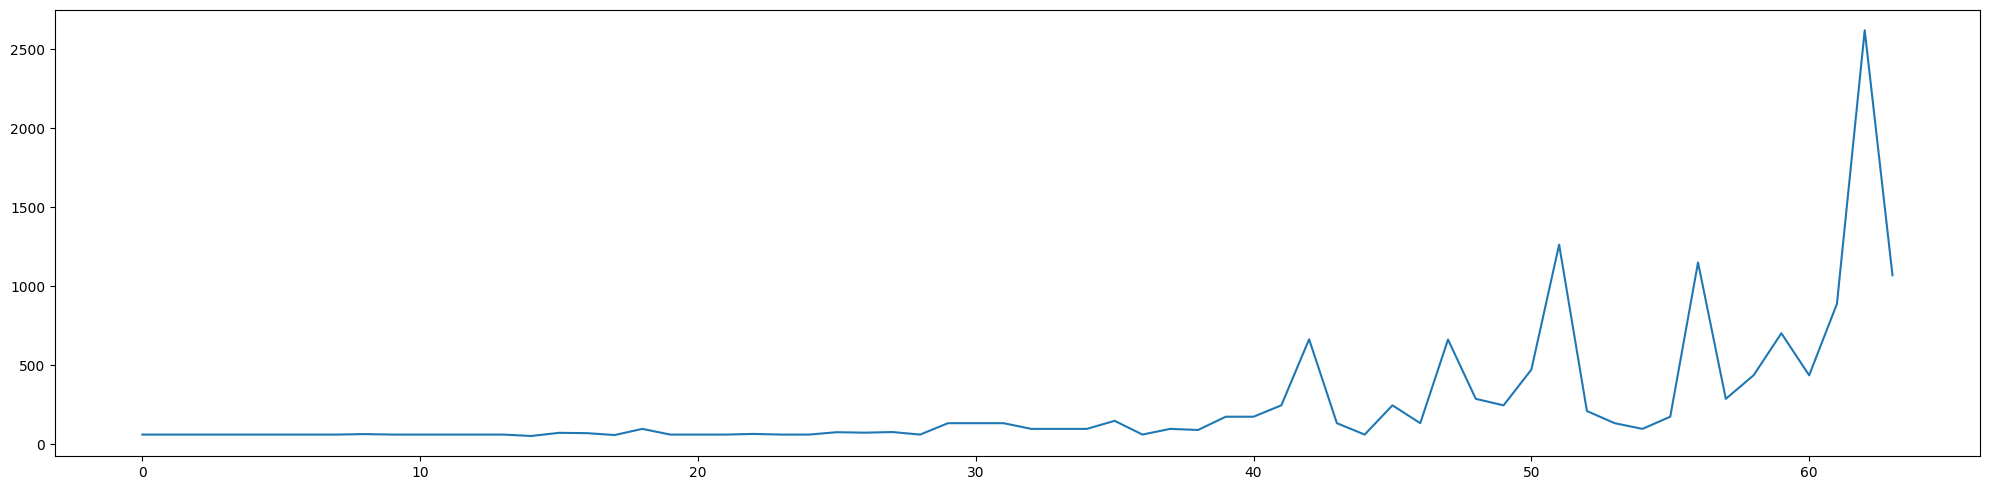

In [9]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

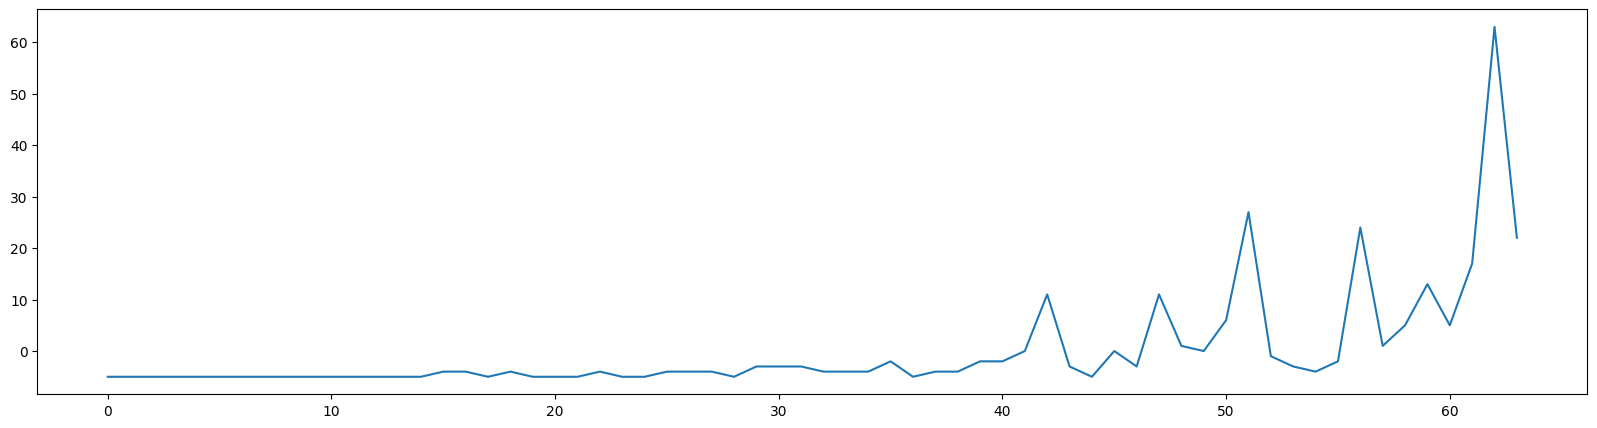

In [10]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

# Sarsa

In [11]:
import math
import copy
from collections import defaultdict

MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5

class Sarsa:
    def __init__(self,
                 bucket_range_per_feature,
                 num_action,
                 t=0,
                 discount_factor=0.99):
        self.update_parameters(t)
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)
        else:
            action = np.argmax(self.q_table[state_idx])
        return action

    def update_policy(self, state, action, reward, state_prime, action_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using SARSA update rule
        self.q_table[state_idx][action] += self.learning_rate * (
            reward + self.discount_factor * self.q_table[state_prime_idx][action_prime] - self.q_table[state_idx][action])

    def get_state_idx(self, state):
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        state_key = [k for k, v in sorted(state.items())]

        state_idx = []
        for key in state_key:
            state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(MIN_EXPLORING_RATE, min(0.5, 0.99**((episode) / 30)))
        self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99**((episode) / 30)))  

    def shutdown_explore(self):
        self.exploring_rate = 0

num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}

sarsa_agent = Sarsa(bucket_range_per_feature, num_action)

In [12]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        sarsa_agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    action = sarsa_agent.select_action(state)
    # cumulate reward for this episode
    cum_reward = 0
    t = 0

    while not env.game_over():
        
        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()
        
        # select an action
        action_prime = sarsa_agent.select_action(state_prime)

        # update agent
        sarsa_agent.update_policy(state, action, reward, state_prime, action_prime)

        # Setting up for the next iteration
        state = state_prime
        action = action_prime
        t += 1

    # update exploring_rate and learning_rate
    sarsa_agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
            episode,
            t,
            cum_reward,
            sarsa_agent.exploring_rate,
            sarsa_agent.learning_rate
        ))
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(sarsa_agent.exploring_rate)
        learning_rates.append(sarsa_agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
len frames: 63
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1500 finished after 60 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.43277903725889943, learning rate: 0.5
Episode 3000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.3660323412732292, learning rate: 0.5
Episode 3500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.30957986252419073, learning rate: 0.5
Episode 4000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.26183394327157605, learning rate: 0.5
Episode 4500 finished after 77 time steps, cumulated reward: -4.0, exploring rate:

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 68 time steps, cumulated reward: -4.0, exploring rate: 0.15841112426184903, learning rate: 0.5
Episode 6000 finished after 125 time steps, cumulated reward: -3.0, exploring rate: 0.13397967485796172, learning rate: 0.5
Episode 6500 finished after 47 time steps, cumulated reward: -5.0, exploring rate: 0.11331624189077398, learning rate: 0.5
Episode 7000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.09583969128049684, learning rate: 0.5
Episode 7500 finished after 70 time steps, cumulated reward: -4.0, exploring rate: 0.08105851616218128, learning rate: 0.5
Episode 8000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.0685570138491429, learning rate: 0.5
Episode 8500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.05798359469728905, learning rate: 0.5
Episode 9000 finished after 73 time steps, cumulated reward: -4.0, exploring rate: 0.04904089407128572, learning rate: 0.5
Episode 9500 fi

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 90 time steps, cumulated reward: -4.0, exploring rate: 0.029670038450977102, learning rate: 0.5
Episode 11000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.02509408428990297, learning rate: 0.5
Episode 11500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.021223870922486707, learning rate: 0.5
Episode 12000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.017950553275045137, learning rate: 0.5
Episode 12500 finished after 99 time steps, cumulated reward: -4.0, exploring rate: 0.015182073244652034, learning rate: 0.5
Episode 13000 finished after 72 time steps, cumulated reward: -4.0, exploring rate: 0.012840570676248398, learning rate: 0.5
Episode 13500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.010860193639877882, learning rate: 0.5
Episode 14000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 14500 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 16000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 16500 finished after 324 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 17000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 17500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 18000 finished after 169 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 18500 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 19000 finished after 297 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 19500 finished after 514 time steps, cumulated reward: 7.0, exploring rate: 0.01, learning rate: 0.5
Episode 20000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 1002 time steps, cumulated reward: 20.0, exploring rate: 0.01, learning rate: 0.5
Episode 21000 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 21500 finished after 401 time steps, cumulated reward: 4.0, exploring rate: 0.01, learning rate: 0.5
Episode 22000 finished after 1305 time steps, cumulated reward: 28.0, exploring rate: 0.01, learning rate: 0.5
Episode 22500 finished after 663 time steps, cumulated reward: 11.0, exploring rate: 0.01, learning rate: 0.5
Episode 23000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 23500 finished after 354 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 24000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 24500 finished after 513 time steps, cumulated reward: 7.0, exploring rate: 0.01, learning rate: 0.5
Episode 25000 

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 288 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 26000 finished after 360 time steps, cumulated reward: 3.0, exploring rate: 0.01, learning rate: 0.5
Episode 26500 finished after 288 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 27000 finished after 900 time steps, cumulated reward: 18.0, exploring rate: 0.01, learning rate: 0.5
Episode 27500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 28000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 28500 finished after 889 time steps, cumulated reward: 17.0, exploring rate: 0.01, learning rate: 0.5
Episode 29000 finished after 890 time steps, cumulated reward: 17.0, exploring rate: 0.01, learning rate: 0.5
Episode 29500 finished after 740 time steps, cumulated reward: 13.0, exploring rate: 0.01, learning rate: 0.5
Episode 30000 f

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 30500 finished after 324 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5
Episode 31000 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 31500 finished after 179 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 32000 finished after 1079 time steps, cumulated reward: 22.0, exploring rate: 0.01, learning rate: 0.5
Episode 32500 finished after 417 time steps, cumulated reward: 5.0, exploring rate: 0.01, learning rate: 0.5
Episode 33000 finished after 966 time steps, cumulated reward: 19.0, exploring rate: 0.01, learning rate: 0.5
Episode 33500 finished after 1273 time steps, cumulated reward: 28.0, exploring rate: 0.01, learning rate: 0.5
Episode 34000 finished after 699 time steps, cumulated reward: 12.0, exploring rate: 0.01, learning rate: 0.5
Episode 34500 finished after 1305 time steps, cumulated reward: 28.0, exploring rate: 0.01, learning rate: 0.5
Episode 35

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 35500 finished after 2096 time steps, cumulated reward: 49.0, exploring rate: 0.01, learning rate: 0.5
Episode 36000 finished after 187 time steps, cumulated reward: -1.0, exploring rate: 0.01, learning rate: 0.5
Episode 36500 finished after 514 time steps, cumulated reward: 7.0, exploring rate: 0.01, learning rate: 0.5
Episode 37000 finished after 1794 time steps, cumulated reward: 41.0, exploring rate: 0.01, learning rate: 0.5
Episode 37500 finished after 1720 time steps, cumulated reward: 40.0, exploring rate: 0.01, learning rate: 0.5
Episode 38000 finished after 1274 time steps, cumulated reward: 28.0, exploring rate: 0.01, learning rate: 0.5
Episode 38500 finished after 2132 time steps, cumulated reward: 50.0, exploring rate: 0.01, learning rate: 0.5
Episode 39000 finished after 854 time steps, cumulated reward: 16.0, exploring rate: 0.01, learning rate: 0.5
Episode 39500 finished after 3714 time steps, cumulated reward: 92.0, exploring rate: 0.01, learning rate: 0.5


KeyboardInterrupt: 

In [18]:
def demo():
    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # shutdown exploration to see performance of greedy action
    sarsa_agent.shutdown_explore()

    # the initial state
    state = game.getGameState()

    while not env.game_over():
        # select an action
        action = sarsa_agent.select_action(state)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # observe the result
        state_prime = game.getGameState()  # get next state

        # Setting up for the next iteration
        state = state_prime

    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
    display(clip.ipython_display(fps=60, autoplay=1, loop=1))


demo()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (112.2) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !

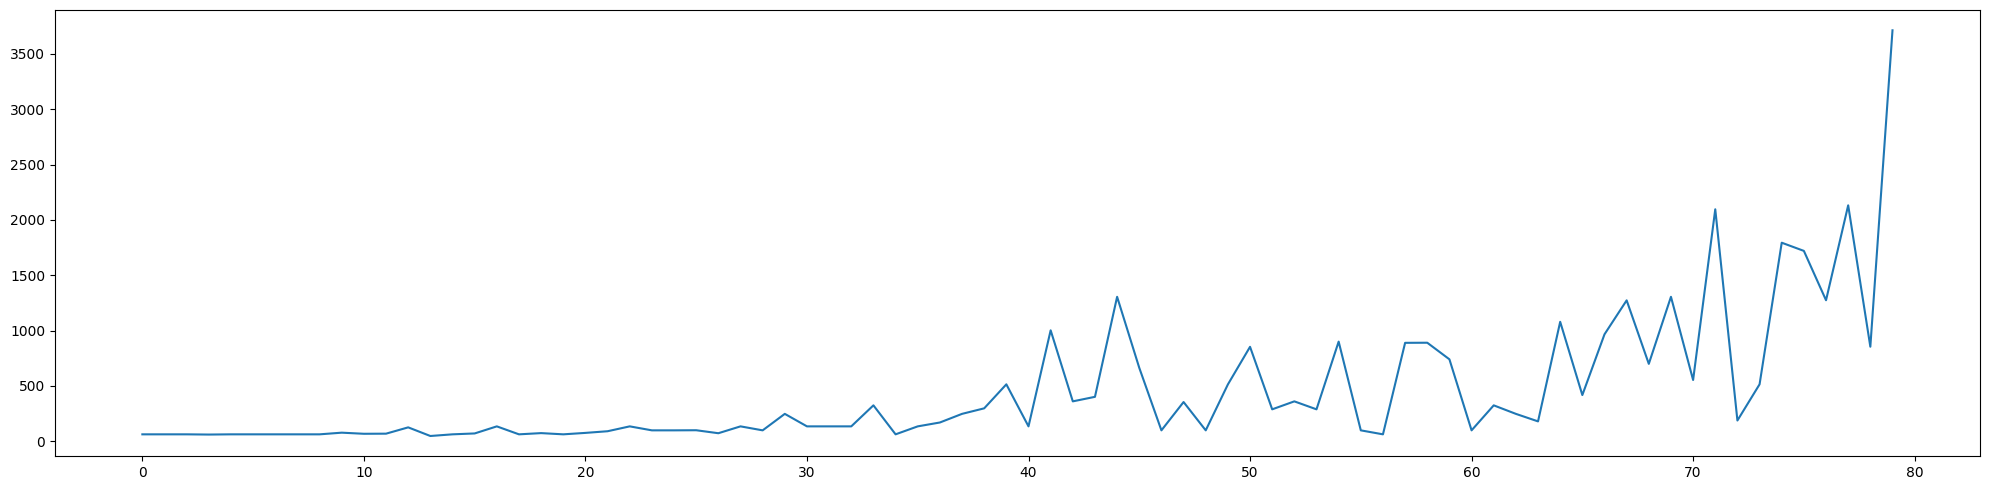

In [15]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

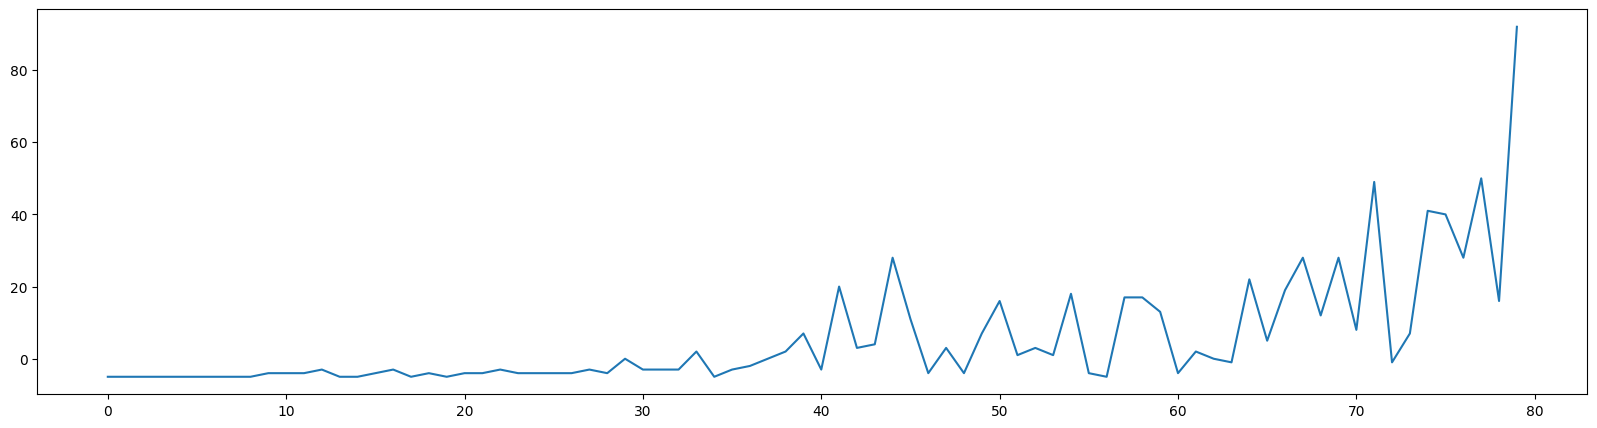

In [16]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

# Discussion

- 我認為 sarsa 在學習上速度比較慢, 但是學會後的 performance 相對而言比較好, 我本來以為學習速度會比 q-learning 快, 但是我好像就卡在 2000, 也可以看到跟 q-learning 比起來 sarsa 會走一些比較靠牆的路線, 但是整體的 performance 會比較好

- 另外不知道為什麼我最後 train 出來的